The MIT License (MIT)

Copyright (c) 2016, [Lumen Novus Incorporated d/b/a SharePoint Experience](http://sharepointexperience.com/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# First off ...

If you are already familiar with Python and the libraries I used in this notebook, I take a *lot* of poetic license in my descriptions of what's going on. Please forgive them :)

# The setup...

Get a few Python modules loaded up first

In [1]:
%matplotlib inline
import requests
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import spacy
from gensim import corpora, models, similarities

from lxml import etree
from bs4 import BeautifulSoup
from IPython.core.display import display, HTML
import re

## More housekeeping

Tables of data will be displayed later - this will allow them to expand and scroll their full width. Also, load up the "brain" for the *Natural Language Processing* library used in this example, **spaCy**.

This can take 30-60 seconds, depending on your computer's processor speed.

In [2]:
pd.set_option('display.max_colwidth', -1)
plt.rcdefaults()

nlp = spacy.English()

## Some SharePoint configuration details

Time to define what SharePoint Online site will be used, and the credentials used to sign into it. Since SharePoint Online supports SAML for authentication, create a template to make the request

# IMPORTANT #

You'll need to update the four variables here to match your SharePoint Online environment. If you're not using SharePoint Online, you'll need to change the code from the following cell all the way down to where `sp_request` is defined.

In [3]:
# Your SharePoint Online domain root goes here, including the / at the end
endpoint = 'https://????.sharepoint.com/'

# Your SharePoint Online user goes here (the user you want to use for authenticating)
username = '????@????.onmicrosoft.com' 

# And your password. Imagine that.
password = 'pass@word1' 

# The URL to the root of the site collection you want to use goes here, including the / at the end
the_site = 'sites/contoso/Employee/ITWeb/Information%20Technology/' 

api_base = '{}{}_api/web/'.format(endpoint, the_site)

request_headers = {
    'Accept': 'application/json',
    'odata': 'verbose',
}

saml_request_template = '<s:Envelope xmlns:s="http://www.w3.org/2003/05/soap-envelope" xmlns:a="http://www.w3.org/2005/08/addressing" xmlns:u="http://docs.oasis-open.org/wss/2004/01/oasis-200401-wss-wssecurity-utility-1.0.xsd"><s:Header><a:Action s:mustUnderstand="1">http://schemas.xmlsoap.org/ws/2005/02/trust/RST/Issue</a:Action><a:ReplyTo><a:Address>http://www.w3.org/2005/08/addressing/anonymous</a:Address></a:ReplyTo><a:To s:mustUnderstand="1">https://login.microsoftonline.com/extSTS.srf</a:To><o:Security s:mustUnderstand="1" xmlns:o="http://docs.oasis-open.org/wss/2004/01/oasis-200401-wss-wssecurity-secext-1.0.xsd"><o:UsernameToken><o:Username>{username}</o:Username><o:Password>{password}</o:Password></o:UsernameToken></o:Security></s:Header><s:Body><t:RequestSecurityToken xmlns:t="http://schemas.xmlsoap.org/ws/2005/02/trust"><wsp:AppliesTo xmlns:wsp="http://schemas.xmlsoap.org/ws/2004/09/policy"><a:EndpointReference><a:Address>{endpoint}</a:Address></a:EndpointReference></wsp:AppliesTo><t:KeyType>http://schemas.xmlsoap.org/ws/2005/05/identity/NoProofKey</t:KeyType><t:RequestType>http://schemas.xmlsoap.org/ws/2005/02/trust/Issue</t:RequestType><t:TokenType>urn:oasis:names:tc:SAML:1.0:assertion</t:TokenType></t:RequestSecurityToken></s:Body></s:Envelope>'
saml_request_body = saml_request_template.format(
    endpoint=endpoint, username=username, password=password)

```<s:Envelope xmlns:s="http://www.w3.org/2003/05/soap-envelope" xmlns:a="http://www.w3.org/2005/08/addressing" xmlns:u="http://docs.oasis-open.org/wss/2004/01/oasis-200401-wss-wssecurity-utility-1.0.xsd">
	<s:Header>
		<a:Action s:mustUnderstand="1">http://schemas.xmlsoap.org/ws/2005/02/trust/RST/Issue</a:Action>
		<a:ReplyTo>
			<a:Address>http://www.w3.org/2005/08/addressing/anonymous</a:Address>
		</a:ReplyTo>
		<a:To s:mustUnderstand="1">https://login.microsoftonline.com/extSTS.srf</a:To>
		<o:Security s:mustUnderstand="1" xmlns:o="http://docs.oasis-open.org/wss/2004/01/oasis-200401-wss-wssecurity-secext-1.0.xsd">
			<o:UsernameToken>
				<o:Username>????@????.onmicrosoft.com</o:Username>
				<o:Password>pass@word1</o:Password>
			</o:UsernameToken>
		</o:Security>
	</s:Header>
	<s:Body>
		<t:RequestSecurityToken xmlns:t="http://schemas.xmlsoap.org/ws/2005/02/trust">
			<wsp:AppliesTo xmlns:wsp="http://schemas.xmlsoap.org/ws/2004/09/policy">
				<a:EndpointReference>
					<a:Address>https://????.sharepoint.com/</a:Address>
				</a:EndpointReference>
			</wsp:AppliesTo>
			<t:KeyType>http://schemas.xmlsoap.org/ws/2005/05/identity/NoProofKey</t:KeyType>
			<t:RequestType>http://schemas.xmlsoap.org/ws/2005/02/trust/Issue</t:RequestType>
			<t:TokenType>urn:oasis:names:tc:SAML:1.0:assertion</t:TokenType>
		</t:RequestSecurityToken>
	</s:Body>
</s:Envelope>```

## So many namespaces

An XML document can actually combine a bunch of different grammars, each one known by a *namespace*. A tag named with a prefix, like `<SharePoint:AwesomeSauce>`, means that the `AwesomeSauce` tag comes from the `SharePoint` namespace.

These namespaces may be useful, so they'll be stored in a Python **dictionary** for use later.

In [4]:
nsmap = {
    'S': 'http://www.w3.org/2003/05/soap-envelope',
    'wsse': 'http://docs.oasis-open.org/wss/2004/01/oasis-200401-wss-wssecurity-secext-1.0.xsd',
    'wsu': 'http://docs.oasis-open.org/wss/2004/01/oasis-200401-wss-wssecurity-utility-1.0.xsd',
    'wsa': 'http://www.w3.org/2005/08/addressing',
    'wst': 'http://schemas.xmlsoap.org/ws/2005/02/trust'
}

## Hello, SharePoint, can I come in?

This function will make a request to SharePoint Online, using the **SAML** template from earlier, and return the response from the request. Hopefully.

In [5]:
def saml_request(body):
    # SharePoint Online REST API - Get Request Security Token
    # POST https://login.microsoftonline.com/extSTS.srf

    try:
        response = requests.post(
            url="https://login.microsoftonline.com/extSTS.srf",
            headers={
                "Accept": "application/json",
            },
            data=body
        )
        return response
    except requests.exceptions.RequestException:
        print('HTTP Request failed')

## Drumroll, please...

Now, to make the request. If all goes well, there will be a special token returned that will be exchanged for the actual right to log in to the site.

In [6]:
s = saml_request(saml_request_body)
saml_response = etree.XML(s.content)
saml_token = saml_response.xpath(
    '//wsse:BinarySecurityToken[@Id="Compact0"]', namespaces=nsmap)[0].text
saml_token

'somerandomjunkwillgohere'

## I have the golden ticket!

Now that the token is returned, it's time to exchange it with the SharePoint Online site used in this example. It's kinda like logging in, but the SharePoint site isn't given the login and password, it's given the ticket that the earlier request returned to us. It will respond with two cookies (***yum!***) that will be used again (and again) for any future requests to the SharePoint Online site.

In [7]:
a = requests.post(
    url="{}_forms/default.aspx?wa=wsignin1.0".format(endpoint),
    data=saml_token
)

## Show me your cookies

Here, the cookies are assigned to a variable we can use whenever we attend a future SharePoint Cookie Exchange.

In [8]:
authcookies = {
    'FedAuth': a.cookies['FedAuth'],
    'rtFa': a.cookies['rtFa']
}

In [9]:
authcookies

{'FedAuth': 'somerandomjunkwillgohere',
 'rtFa': 'somerandomjunkwillgohere'}

## Hey, DJ, I have a SharePoint request

This function will handle common SharePoint requests. It supplies the previously-captured authentication cookies, and will return a **Pandas DataFrame** of the results of the request.

In [10]:
def sp_request(path_from_base, fields_to_keep, index_on_id=True):
    r = requests.get(
        url="{}{}".format(api_base, path_from_base),
        cookies=authcookies,
        headers=request_headers
    )
    j = r.json()
    v = j['value']

    df = pd.DataFrame(v)
    df = df[fields_to_keep]
    if index_on_id:
        df.set_index('Id', inplace=True)
    return df

## Who's there?

First, the list of users is returned by the `sp_request` function and assigned to the variable `df_users`.

In [11]:
df_users = sp_request('siteusers', ['Id', 'Email', 'Title'])

In [12]:
df_users

,Email,Title
Id,,
23,AlexD@lnidemo.onmicrosoft.com,Alex Darrow
24,AllieB@lnidemo.onmicrosoft.com,Allie Bellew
25,AnneW@lnidemo.onmicrosoft.com,Anne Wallace
26,AzizH@lnidemo.onmicrosoft.com,Aziz Hassouneh
27,BelindaN@lnidemo.onmicrosoft.com,Belinda Newman
28,BonnieK@lnidemo.onmicrosoft.com,Bonnie Kearney
29,DavidL@lnidemo.onmicrosoft.com,David Longmuir
30,DenisD@lnidemo.onmicrosoft.com,Denis Dehenne
31,DorenaP@lnidemo.onmicrosoft.com,Dorena Paschke


## Yo dawg, I hear you like lists of lists

Now, `sp_request` is used to return a list of lists, and filtered to only include lists that aren't marked as hidden.

In [13]:
df_lists_all = sp_request(
    'lists', ['Title', 'Description', 'ItemCount', 'Id', 'Hidden'])
df_lists = df_lists_all[df_lists_all.Hidden == False]

In [14]:
# Top 5 lists
df_lists.sort(['ItemCount'], ascending=False).head()

,Title,Description,ItemCount,Hidden
Id,,,,
0e5f4ea4-cefc-4137-926e-476396f620bc,Discussions List,"Use the Discussion list to hold forum-style conversations, including question and answer, on topics relevant to your team, project, or community.",41,False
389381be-4e08-488e-9f62-94f6615ed487,Community Members,This list keeps a record of ongoing activity by members and reputation they accrue within this community.,13,False
a8648997-cb67-4aff-8eae-ed782e5cb4b8,Site Pages,,6,False
d1e1de69-2934-4904-b128-b2509a763635,Categories,Use the Categories list to define the categories available for discussion list posts.,1,False
fa06102c-e32e-42fa-8a34-d312d7352a2e,Documents,This system library was created by the Publishing feature to store documents that are used on pages in this site.,0,False


## Time to visit the watercooler

And let's see .. what are people discussing? 

First, `discussion_id` is set to the ID of the list titled **Discussions List**. Then, `tmp_discussions` (so named because it isn't intended to be the final copy of this dataset) is set to the listing of discussion content.

In [15]:
discussion_id = df_lists[df_lists.Title == 'Discussions List'].index.values[0]

tmp_discussions = sp_request(
    path_from_base="lists(guid'{}')/items".format(discussion_id),
    fields_to_keep=[
        'Title', 'Body', 'AuthorId', 'Id', 'ParentItemID', 'BestAnswerId'],
    index_on_id=False
)

In [16]:
tmp_discussions

,Title,Body,AuthorId,Id,ParentItemID,BestAnswerId
0,"Update to Office, Available Soon!","<div class=""ExternalClass7680EB0FE93243B1919ABD9B621E78F3""><p>The new release of Office will is right around the corner&#160; <span><span>​I am not sure when Contoso is planning to upgrade, but </span></span>I know I will be getting the new version as soon as I can.&#160; <br></p></div>",32,1,NaN,3
1,None,"<div class=""ExternalClass4889D37A14C34CE7BB830F5A7FF38A96""><p>​​I am glad you are so up-to-date on things Fabrice! &#160;I will try to get the new version soon as well.</p></div>",41,2,1,NaN
2,None,"<div class=""ExternalClassF913E494E9CC465C86A6F1692A0E86FC""><p>Sounds good Fabrice!&#160; Let me know if you need someone to help troubleshoot something with you.</p></div>",42,3,1,NaN
3,None,"<div class=""ExternalClassB2DC0D9515FC4291903985A825BBA466""><p>Anyone know what some of the new features are?</p></div>",38,4,1,NaN
4,None,"<div class=""ExternalClass85990E08E2C24CD296E6711B5D5312ED""><p>The Microsoft site has a full description of the new Office products.<br></p></div>",32,5,1,NaN
5,Microsoft Issues Word Patch,"<div class=""ExternalClass1A1D176690C04027BB797CAF92E32C80""><p>​Make sure to update your systems, because Microsoft has released a critical patch for Word. &#160;This should help smooth over some of the difficulties we have been having and&#160;​give the Security team a rest. &#160;Even so, remember not to open files unless they are from a trusted source!</p></div>",34,6,NaN,NaN
6,None,"<div class=""ExternalClass66B34417A321490DAE6A30D413D87F74""><p>​This is a helpful reminder, Garth. &#160;I will remember to set up the update before I leave for the weekend. &#160;</p></div>",35,7,6,NaN
7,None,"<div class=""ExternalClass9EEA8838B7D34AA2A1083C7166DDFBC7""><p>Thanks.&#160; I just got the patch.</p></div>",38,8,6,NaN
8,None,"<div class=""ExternalClass7CDA6082559245648E3B114FD0F1A15F""><p>​I am glad it got fixed up so quickly, I don't think anyone from Contoso had problems with it!</p></div>",41,9,6,NaN
9,Windows 10 PCs for Next Year,"<div class=""ExternalClass8459219F464C4AD3B72DDF6ED7AB52C9""><p>​It has been confirmed that the next round of hardware replacements will be windows 10 PCs, to be handed out sometime​ after the first of the year to avoid interference with ongoing holiday projects. &#160;</p></div>",35,10,NaN,13


## HTML is nice, but plain text is ... well, plain.

Natural Language Processing works better when you're processing a single language — in this case, English — so the `makeplain` function will use the Python module **BeautifulSoup** to remove all the HTML. A regular expression is also used to remove some other whitespace-related characters to help clean up the text.

In [17]:
def makeplain(html):
    text = BeautifulSoup(html, 'html.parser').get_text()
    text = text.replace(u'\u200b','')
    text = text.replace(u'\xa0','')
    return text

## Correlate all the things

The `df_users` DataFrame and the `tmp_discussions` DataFrame are merged together, so that the resulting dataframe (`df_discussions`) includes the Authors' names and email addresses.

In [18]:
df_discussions = tmp_discussions.merge(
    df_users, left_on=tmp_discussions.AuthorId, right_on=df_users.index.values, suffixes=['_disc', '_user'])
df_discussions.set_index('Id', inplace=True)
df_discussions['Body_Text'] = df_discussions.apply(
    lambda row: makeplain(row['Body']), axis=1)
df_discussions = df_discussions[['Title_user', 'Title_disc', 'Body_Text', 'Body', 'AuthorId', 'ParentItemID', 'BestAnswerId',
                                 'Email']]

## Who's really contributing to the community?

Here, the discussions are grouped by author, and a graph is plotted to show how many posts each user has made, and how many posts they've marked as an answer, a metric that may show how much they're truly contributing to rather than "leeching" from the community.

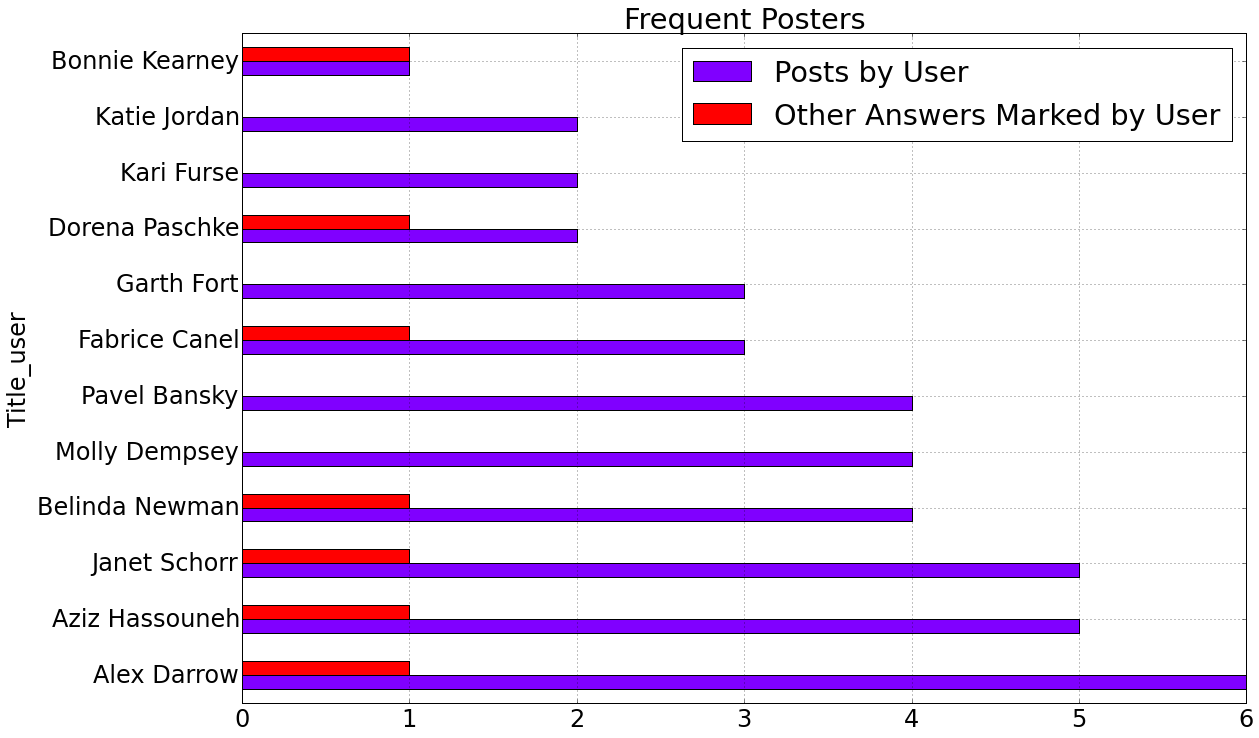

In [19]:
%matplotlib inline
plt.rcParams.update({
    'figure.facecolor': 'white',
    'font.size': '24',
    'axes.grid': 'true',
})

grouped = df_discussions.groupby(['Title_user']).count().sort(
    ['Title_disc'], ascending=False)
grouped[['Title_disc', 'BestAnswerId']].plot(
    kind='barh', title='Frequent Posters', figsize=(18, 12), colormap='rainbow')
plt.legend(['Posts by User', 'Other Answers Marked by User'])

## Who's the best?

The posts marked as "best answers" *may* be used to identify subject matter experts, so `best_answers` is populated with a DataFrame of only those discussions that have been marked as a best answer.

In [20]:
best_answer_ids = df_discussions.BestAnswerId.dropna().values
best_answers = df_discussions[df_discussions.index.isin(best_answer_ids)].Body.values

for answer in best_answers:
    display(HTML(answer))

## Time to investigate the content further

`discussion_bodies` is set to a plain list (technically, a Python list that's been *enhanced* as a *NumPy array*) of the plain text discussions. This will be used to create a **corpus**, or body of content.

In [21]:
df_discussions.sort_index(inplace=True)
discussion_bodies = df_discussions.Body_Text.values
discussion_bodies[:5]

array([ 'The new release of Office will is right around the corner I am not sure when Contoso is planning to upgrade, but I know I will be getting the new version as soon as I can. ',
       'I am glad you are so up-to-date on things Fabrice! I will try to get the new version soon as well.',
       'Sounds good Fabrice! Let me know if you need someone to help troubleshoot something with you.',
       'Anyone know what some of the new features are?',
       'The Microsoft site has a full description of the new Office products.'], dtype=object)

## STOP! We don't like those words...

Some words don't really contribute to the ability to discern important words or topics. These words, like **the**, **of**, **altogether**, or **whereby**, are called **stopwords**. **SpaCy** has its own list of them, and a few bits of punctuation and partial contracts are added to that list. Finally, `texts` is set to a list of lists of words. One list for each of the original discussions.

In [22]:
my_stop_list = set('the of is - . , ? ! \'s ca n\'t'.split())
stoplist = my_stop_list.union(spacy.en.STOPWORDS)

texts = [
    [word.lower_ for word in nlp(discussion) 
     if word.lower_ not in stoplist] 
    for discussion in discussion_bodies
]

## The most popular words are...

`frequency` is set as a **dictionary** of words and their frequencies. Each word gets an entry in the dictionary, and each time the word appears, its count is increased. Words that appear only once are filtered out and set to the variable `texts`. Since this is still a list (one entry for each of the discussions themselves) of lists (of those "relevant" words, that appeared more than once in the entire **corpus**), it's easily assigned as a new column in the `df_discussions` DataFrame.

In [23]:
from collections import defaultdict

frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1
        
texts = [[token for token in text if frequency[token] > 1]
         for text in texts]

df_discussions['relevant_words'] = texts

## Show me the ~~money~~ text.

Here's the list of the "relevant" words for each discussion:

In [24]:
i = 0
for text in texts:
    i += 1
    print(i,text)

1 ['new', 'office', 'right', 'sure', 'contoso', 'upgrade', 'know', 'new', 'version', 'soon']
2 ['glad', 'things', 'fabrice', 'try', 'new', 'version', 'soon']
3 ['fabrice', 'know', 'need', 'help']
4 ['know', 'new']
5 ['microsoft', 'site', 'new', 'office', 'products']
6 ['sure', 'update', 'microsoft', 'released', 'patch', 'word', 'help', 'having', 'security', 'remember']
7 ['helpful', 'remember', 'update']
8 ['thanks', 'got', 'patch']
9 ['glad', 'got', 'think', 'contoso', 'problems']
10 ['confirmed', 'round', 'hardware', 'pcs', 'year', 'holiday', 'projects']
11 ['new', 'hardware', 'new', 'product']
12 ['help', 'desk', 'holiday', 'upgrade']
13 ['think', 'check', 'garret', 'vargas', 'able', 'help', 'need', 'things']
14 ['thanks']
15 ['like', 'contoso', 'electronics', 'right', 'contoso', 'latest', 'contoso', 'products', 'new', 'week']
16 ['time', 'project', 'try', 'idea', 'year']
17 ['like', 'year']
18 ['think', 'soon']
19 ['year', 'projects', 'heard', 'helpful']
20 ['remember', 'scheduled'

## Words? Where we're going, we don't need words.

A new variable `dictionary` is created to store a special object from the **corpora** module of the **gensim** library. This is responsible for indexing the words and assigning them to numbers.

In [25]:
dictionary = corpora.Dictionary(texts)
dictionary.save('contoso.dict')

## Words can be assigned numbers?

Yep. Proof:

In [26]:
print(dictionary.token2id)

{'number': 68, 'heard': 50, 'office': 0, 'upgrade': 3, 'update': 22, 'internet': 69, 'problems': 29, 'thank': 61, 'sure': 7, 'use': 67, 'week': 43, 'released': 19, 'email': 72, 'current': 60, 'operations': 55, 'ago': 63, 'latest': 45, 'work': 70, 'product': 37, 'need': 13, 'got': 27, 'pcs': 32, 'check': 39, 'scheduled': 51, 'fabrice': 12, 'november': 56, 'soon': 8, 'firefox': 71, 'reading': 58, 'saw': 62, 'security': 24, 'home': 66, 'projects': 34, 'things': 9, 'desk': 38, 'year': 35, 'version': 5, 'helpful': 25, 'microsoft': 15, 'glad': 10, 'able': 40, 'having': 20, 'confirmed': 31, 'like': 46, 'changes': 52, 'garret': 41, 'patch': 23, 'know': 6, 'tablet': 74, 'right': 1, 'round': 30, 'explorer': 65, 'think': 28, 'time': 47, 'thanks': 26, 'site': 17, 'products': 16, 'contoso': 2, 'remember': 21, 'vargas': 42, 'try': 11, 'idea': 49, 'new': 4, 'help': 14, 'updates': 54, 'word': 18, 'request': 73, 'wondering': 59, 'cyber': 57, 'hardware': 33, 'page': 53, 'form': 75, 'project': 48, 'elect

## Save the corpus!

Sounds like a new charity, but in this case, the **gensim** library is used to save a **corpus** as in a special format called **bag of words (bow)**. There are a few file formats for those, and the [Matrix Market](http://math.nist.gov/MatrixMarket/formats.html) format is one of the most common ones, which could be helpful if this corpus would be processed in its numeric form by another library.

In [27]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('contoso.mm', corpus)

## What are the REALLY important words

Now, a **model**, or another form of numeric representation of the **corpus**, is trained based on a techique called *Term Frequency / Inverse Document Frequency*.

Just because a word appears often in the entire corpus, it doesn't mean that it can be used to classify individual discussions. The **stopwords** won't catch any industry-specific terms, for example. If a word or phrase is used a lot in a few posts, that word or phrase could be relevant when determining the topic of that discussion. **TF/IDF** is a great way to identity *truly* relevant words or phrases. In this example, only words are considered.

In [28]:
tfidf = models.TfidfModel(corpus, normalize=True)

## Corpus transformation

The corpus is now transformed to match the trained **TF/IDF model**. Before, the numeric representation was based on the **bag of words** model (how much times each word appears), and after the transformation, the numeric representation will be based on the times each word appears in the whole corpus and scaled by how many individual discussions use that word. The actual math is considerably more complex than that:

$$idf(t,D) = log{{N}\over{|\{d \in D : t \in d\}|}}$$

Where:
**idf(t, D)** is the inverse document frequency of the term *t* in our set of discussions *D*, and *N* is the total number of discussions in the corpus.

In [29]:
corpus_tfidf = tfidf[corpus]

## Time to discover the topics

The numeric representation of the corpus is transformed again using another method called *[Latent Semantic Indexing](https://en.wikipedia.org/wiki/Latent_semantic_indexing#cite_note-deerwester1988-1)*, which aims to discover (using some clever maths) the words that seem to be associated together frequently, which may suggest they contribute to an overall *topic*. In this case, the number of topics is limited to **5**.

In [30]:
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=5)
corpus_lsi = lsi[corpus_tfidf]
topics = lsi.show_topics()

## Labelling the topics

The key words for each of the five discovered topics are displayed. This **corpus** doesn't have that many discussion documents, so it's hard to come up with actual topics for them, so they're labeled with generic names, which are stored in `topic_labels`

In [31]:
topic_words = []
for topic in topics:
    topic = re.split('[^A-Za-z]',topic)
    topic = [token for token in topic if token != '']
    topic_words.append(topic)
    print(topic)

topic_labels = ['Topic A','Topic B', 'Topic C', 'Topic D', 'Topic E']

['new', 'think', 'contoso', 'security', 'know', 'help', 'garret', 'like', 'soon', 'products']
['think', 'like', 'products', 'year', 'vargas', 'new', 'able', 'garret', 'changes', 'help']
['thanks', 'patch', 'having', 'got', 'new', 'know', 'week', 'update', 'remember', 'problems']
['year', 'helpful', 'know', 'projects', 'soon', 'holiday', 'operations', 'round', 'security', 'contoso']
['use', 'changes', 'year', 'internet', 'home', 'explorer', 'work', 'think', 'security', 'thanks']


## For future use, store the topic keywords

Each discussion's "topic words" are stored with the discussion in the `df_discussions` dataframe, in case they're useful later. They're sorted by their relative contribution to the overall topic. The topic names and IDs are then calculated and stored in the `df_discussions` dataframe.

In [32]:
best_topics = []
best_topic_labels = []
lsi_topics = [lsi for lsi in corpus_lsi]
for lsi in lsi_topics:
    if lsi:
        lsi.sort(key=lambda tup: tup[1], reverse=True)
        topic_id = lsi[0][0]
        best_topics.append(topic_id)
        best_topic_labels.append(topic_labels[topic_id])
    else:
        best_topics.append('unknown')
        best_topic_labels.append('unknown')

# The story so far...

Time to print the `df_discussions` DataFrame to see how it looks so far.

In [33]:
df_discussions

,Title_user,Title_disc,Body_Text,Body,AuthorId,ParentItemID,BestAnswerId,Email,relevant_words
Id,,,,,,,,,
1,Fabrice Canel,"Update to Office, Available Soon!","The new release of Office will is right around the corner I am not sure when Contoso is planning to upgrade, but I know I will be getting the new version as soon as I can.","<div class=""ExternalClass7680EB0FE93243B1919ABD9B621E78F3""><p>The new release of Office will is right around the corner&#160; <span><span>​I am not sure when Contoso is planning to upgrade, but </span></span>I know I will be getting the new version as soon as I can.&#160; <br></p></div>",32,NaN,3,FabriceC@lnidemo.onmicrosoft.com,"[new, office, right, sure, contoso, upgrade, know, new, version, soon]"
2,Molly Dempsey,None,I am glad you are so up-to-date on things Fabrice! I will try to get the new version soon as well.,"<div class=""ExternalClass4889D37A14C34CE7BB830F5A7FF38A96""><p>​​I am glad you are so up-to-date on things Fabrice! &#160;I will try to get the new version soon as well.</p></div>",41,1,NaN,MollyD@lnidemo.onmicrosoft.com,"[glad, things, fabrice, try, new, version, soon]"
3,Pavel Bansky,None,Sounds good Fabrice! Let me know if you need someone to help troubleshoot something with you.,"<div class=""ExternalClassF913E494E9CC465C86A6F1692A0E86FC""><p>Sounds good Fabrice!&#160; Let me know if you need someone to help troubleshoot something with you.</p></div>",42,1,NaN,PavelB@lnidemo.onmicrosoft.com,"[fabrice, know, need, help]"
4,Kari Furse,None,Anyone know what some of the new features are?,"<div class=""ExternalClassB2DC0D9515FC4291903985A825BBA466""><p>Anyone know what some of the new features are?</p></div>",38,1,NaN,KariF@lnidemo.onmicrosoft.com,"[know, new]"
5,Fabrice Canel,None,The Microsoft site has a full description of the new Office products.,"<div class=""ExternalClass85990E08E2C24CD296E6711B5D5312ED""><p>The Microsoft site has a full description of the new Office products.<br></p></div>",32,1,NaN,FabriceC@lnidemo.onmicrosoft.com,"[microsoft, site, new, office, products]"
6,Garth Fort,Microsoft Issues Word Patch,"Make sure to update your systems, because Microsoft has released a critical patch for Word. This should help smooth over some of the difficulties we have been having andgive the Security team a rest. Even so, remember not to open files unless they are from a trusted source!","<div class=""ExternalClass1A1D176690C04027BB797CAF92E32C80""><p>​Make sure to update your systems, because Microsoft has released a critical patch for Word. &#160;This should help smooth over some of the difficulties we have been having and&#160;​give the Security team a rest. &#160;Even so, remember not to open files unless they are from a trusted source!</p></div>",34,NaN,NaN,GarthF@lnidemo.onmicrosoft.com,"[sure, update, microsoft, released, patch, word, help, having, security, remember]"
7,Janet Schorr,None,"This is a helpful reminder, Garth. I will remember to set up the update before I leave for the weekend.","<div class=""ExternalClass66B34417A321490DAE6A30D413D87F74""><p>​This is a helpful reminder, Garth. &#160;I will remember to set up the update before I leave for the weekend. &#160;</p></div>",35,6,NaN,JanetS@lnidemo.onmicrosoft.com,"[helpful, remember, update]"
8,Kari Furse,None,Thanks. I just got the patch.,"<div class=""ExternalClass9EEA8838B7D34AA2A1083C7166DDFBC7""><p>Thanks.&#160; I just got the patch.</p></div>",38,6,NaN,KariF@lnidemo.onmicrosoft.com,"[thanks, got, patch]"
9,Molly Dempsey,None,"I am glad it got fixed up so quickly, I don't think anyone from Contoso had problems with it!","<div class=""ExternalClass7CDA6082559245648E3B114FD0F1A15F""><p>​I am glad it got fixed up so quickly, I don't think anyone from Contoso had problems with it!</p></div>",41,6,NaN,MollyD@lnidemo.onmicrosoft.com,"[glad, got, think, contoso, problems]"


## It's words ... in ~~Space~~ SpaCy

Using SpaCy, the *noun phrases* and any organization or person *named entities* are discovered, and added to the `df_discussions` DataFrame.

In [34]:
disc_np = []
disc_op = []

for entry in discussion_bodies:
    doc = nlp(entry)
    nounphrases_and_head = [[np.orth_, np.root.head.orth_] for np in doc.noun_chunks]
    nounphrases = [np.orth_ for np in doc.noun_chunks]
    entities = list(doc.ents)
    orgs_and_people = [entity.orth_ for entity in entities if entity.label_ in ['ORG','PERSON']]
    disc_np.append(', '.join(nounphrases))
    disc_op.append(', '.join(orgs_and_people))

df_discussions['noun_phrases'] = disc_np
df_discussions['orgs_and_people'] = disc_op

## How's it looking now?

Time to print the `df_discussions` DataFrame again, just to see the new stuff (scroll to the right of the table)

In [35]:
df_discussions

,Title_user,Title_disc,Body_Text,Body,AuthorId,ParentItemID,BestAnswerId,Email,relevant_words,noun_phrases,orgs_and_people
Id,,,,,,,,,,,
1,Fabrice Canel,"Update to Office, Available Soon!","The new release of Office will is right around the corner I am not sure when Contoso is planning to upgrade, but I know I will be getting the new version as soon as I can.","<div class=""ExternalClass7680EB0FE93243B1919ABD9B621E78F3""><p>The new release of Office will is right around the corner&#160; <span><span>​I am not sure when Contoso is planning to upgrade, but </span></span>I know I will be getting the new version as soon as I can.&#160; <br></p></div>",32,NaN,3,FabriceC@lnidemo.onmicrosoft.com,"[new, office, right, sure, contoso, upgrade, know, new, version, soon]","The new release, Office, the corner, I, Contoso, I, I, the new version, I",Contoso
2,Molly Dempsey,None,I am glad you are so up-to-date on things Fabrice! I will try to get the new version soon as well.,"<div class=""ExternalClass4889D37A14C34CE7BB830F5A7FF38A96""><p>​​I am glad you are so up-to-date on things Fabrice! &#160;I will try to get the new version soon as well.</p></div>",41,1,NaN,MollyD@lnidemo.onmicrosoft.com,"[glad, things, fabrice, try, new, version, soon]","I, you, things, I, the new version",
3,Pavel Bansky,None,Sounds good Fabrice! Let me know if you need someone to help troubleshoot something with you.,"<div class=""ExternalClassF913E494E9CC465C86A6F1692A0E86FC""><p>Sounds good Fabrice!&#160; Let me know if you need someone to help troubleshoot something with you.</p></div>",42,1,NaN,PavelB@lnidemo.onmicrosoft.com,"[fabrice, know, need, help]","me, you, someone, something, you",
4,Kari Furse,None,Anyone know what some of the new features are?,"<div class=""ExternalClassB2DC0D9515FC4291903985A825BBA466""><p>Anyone know what some of the new features are?</p></div>",38,1,NaN,KariF@lnidemo.onmicrosoft.com,"[know, new]","Anyone, what, the new features",
5,Fabrice Canel,None,The Microsoft site has a full description of the new Office products.,"<div class=""ExternalClass85990E08E2C24CD296E6711B5D5312ED""><p>The Microsoft site has a full description of the new Office products.<br></p></div>",32,1,NaN,FabriceC@lnidemo.onmicrosoft.com,"[microsoft, site, new, office, products]","The Microsoft site, a full description, the new Office products","Microsoft, Office"
6,Garth Fort,Microsoft Issues Word Patch,"Make sure to update your systems, because Microsoft has released a critical patch for Word. This should help smooth over some of the difficulties we have been having andgive the Security team a rest. Even so, remember not to open files unless they are from a trusted source!","<div class=""ExternalClass1A1D176690C04027BB797CAF92E32C80""><p>​Make sure to update your systems, because Microsoft has released a critical patch for Word. &#160;This should help smooth over some of the difficulties we have been having and&#160;​give the Security team a rest. &#160;Even so, remember not to open files unless they are from a trusted source!</p></div>",34,NaN,NaN,GarthF@lnidemo.onmicrosoft.com,"[sure, update, microsoft, released, patch, word, help, having, security, remember]","your systems, Microsoft, a critical patch, Word, the difficulties, we, andgive, the Security team, the Security team a rest, files, they, a trusted source",Microsoft
7,Janet Schorr,None,"This is a helpful reminder, Garth. I will remember to set up the update before I leave for the weekend.","<div class=""ExternalClass66B34417A321490DAE6A30D413D87F74""><p>​This is a helpful reminder, Garth. &#160;I will remember to set up the update before I leave for the weekend. &#160;</p></div>",35,6,NaN,JanetS@lnidemo.onmicrosoft.com,"[helpful, remember, update]","a helpful reminder, I, the update, I, the weekend",Garth
8,Kari Furse,None,Thanks. I just got the patch.,"<div class=""ExternalClass9EEA8838B7D34AA2A1083C7166DDFBC7""><p>Thanks.&#160; I just got the patch.</p></div>",38,6,NaN,KariF@lnidemo.onmicrosoft.com,"

## Excel users, fear not

You aren't left out. The `df_discussions` DataFrame is saved to a CSV file for later examination with Excel.

In [36]:
df_discussions.to_csv('contoso.csv')

## Who's active on the site (and who's not)

Using the list of **AuthorId** values from the `df_discussions` DataFrame, the `active_users` variable is set to a filtered copy of the original `df_users` DataFrame. The inverse of that list of authors is used to populate `inactive_users` with another filtered copy of `df_users`.

In [37]:
active_user_ids = set(df_discussions.AuthorId.values)
active_users = df_users[df_users.index.isin(active_user_ids)]
inactive_users = df_users[~df_users.index.isin(active_user_ids)]
inactive_users = inactive_users[~(inactive_users.Email == "")]

display(HTML('<h2>Active Users</h2>'))
display(HTML(active_users.to_html()))
display(HTML('<h2>Inactive Users</h2>'))
display(HTML(inactive_users.to_html()))

,Email,Title
Id,,
23,AlexD@lnidemo.onmicrosoft.com,Alex Darrow
26,AzizH@lnidemo.onmicrosoft.com,Aziz Hassouneh
27,BelindaN@lnidemo.onmicrosoft.com,Belinda Newman
28,BonnieK@lnidemo.onmicrosoft.com,Bonnie Kearney
31,DorenaP@lnidemo.onmicrosoft.com,Dorena Paschke
32,FabriceC@lnidemo.onmicrosoft.com,Fabrice Canel
34,GarthF@lnidemo.onmicrosoft.com,Garth Fort
35,JanetS@lnidemo.onmicrosoft.com,Janet Schorr
38,KariF@lnidemo.onmicrosoft.com,Kari Furse


,Email,Title
Id,,
24,AllieB@lnidemo.onmicrosoft.com,Allie Bellew
25,AnneW@lnidemo.onmicrosoft.com,Anne Wallace
29,DavidL@lnidemo.onmicrosoft.com,David Longmuir
30,DenisD@lnidemo.onmicrosoft.com,Denis Dehenne
33,GarretV@lnidemo.onmicrosoft.com,Garret Vargas
36,JulianI@lnidemo.onmicrosoft.com,Julian Isla
37,JunminH@lnidemo.onmicrosoft.com,Junmin Hao
17,admin@lnidemo.onmicrosoft.com,MOD Administrator
40,RobinC@lnidemo.onmicrosoft.com,Robin Counts


## Just for fun...


Just for fun, here's a word cloud of ALL the words from the discussions list.

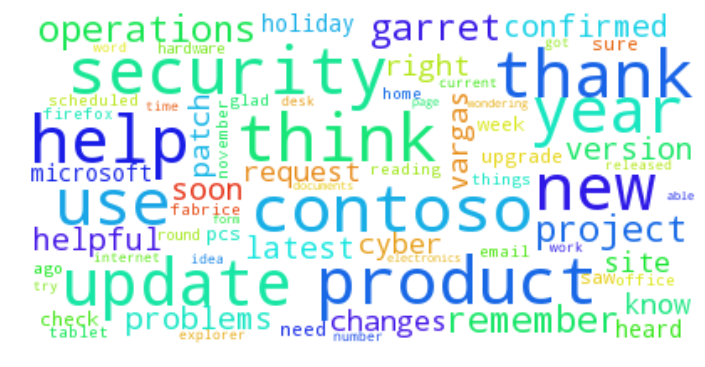

In [38]:
%matplotlib inline
from wordcloud import WordCloud

wctext = ' '.join([word for sublist in texts for word in sublist])


# take relative word frequencies into account, lower max_font_size
wc = WordCloud(background_color="white", max_font_size=40)
wc.generate(wctext)
plt.figure(figsize=(12,12))
plt.imshow(wc)
plt.axis("off")
plt.show()